下面给你一套**“完整可写进论文/报告”的 EDA（探索性数据分析）流程**，专门针对你这份 **DWTS/MCM C 题**数据（`2026_MCM_Problem_C_Data.csv`）。我会按**标准顺序**走，每一步都讲清楚：

* **目的是什么**
* **你要看什么输出**
* **为什么对后面建模重要**
* **这份数据的“坑”在哪里**
* 给你**对应的 Python 代码（可直接复制进 ipynb）**

> 你现在的数据特点（你已经跑出来的）：
> `421×53`、`44`个 score 列（11周×4评委）、`Withdrew=10`、存在 `judge_count=2`（S34 W1）、存在 >10 的分数（bonus/多舞均分导致）。

# 0）你要先明确：这次 EDA 是为谁服务？

你的 EDA 不是为了“看看数据好不好看”，而是为了后面三件事：

1. **Q1 倒推观众投票份额/票数**（核心：每周淘汰机制 + 周内标准化）
2. **Q2 判断赛制变动（rank vs percent，尤其第28季假设）**（核心：不同赛制对应不同约束）
3. **Q3 做解释/预测（行业/年龄/搭档等因素对结果影响）**（核心：跨季比较要可比）

所以 EDA 的输出必须能回答：

* 哪些周/哪些人可以用于 Q1（干净的“投票淘汰周”）
* 哪些是结构性缺失（N/A 不该填）
* 哪些是特殊事件（Withdrew、多淘汰、无人淘汰）

---

# 1）Step 1：读取数据 + 明确粒度（每行是什么）

## 目的

确认“每行=什么”，避免你把宽表当成普通表乱建模。

## 你要知道

这份数据 **每行 = 某个明星在某一季（season）的整体记录**，但里面塞了很多周的分数列（宽表）。
**真正建模单位**通常应是：`(season, celebrity, week)`。

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

CSV_PATH = "2026_MCM_Problem_C_Data.csv"
raw = pd.read_csv(CSV_PATH)

print("shape:", raw.shape)
raw.head(5)

shape: (421, 53)


,celebrity_name,ballroom_partner,celebrity_industry,celebrity_homestate,celebrity_homecountry/region,celebrity_age_during_season,season,results,placement,week1_judge1_score,week1_judge2_score,week1_judge3_score,week1_judge4_score,week2_judge1_score,week2_judge2_score,week2_judge3_score,week2_judge4_score,week3_judge1_score,week3_judge2_score,week3_judge3_score,week3_judge4_score,week4_judge1_score,week4_judge2_score,week4_judge3_score,week4_judge4_score,week5_judge1_score,week5_judge2_score,week5_judge3_score,week5_judge4_score,week6_judge1_score,week6_judge2_score,week6_judge3_score,week6_judge4_score,week7_judge1_score,week7_judge2_score,week7_judge3_score,week7_judge4_score,week8_judge1_score,week8_judge2_score,week8_judge3_score,week8_judge4_score,week9_judge1_score,week9_judge2_score,week9_judge3_score,week9_judge4_score,week10_judge1_score,week10_judge2_score,week10_judge3_score,week10_judge4_score,week11_judge1_score,week11_judge2_score,week11_judge3_score,week11_judge4_score
0,John O'Hurley,Charlotte Jorgensen,Actor/Actress,Maine,United States,50,1,2nd Place,2,7.0,7.0,6.0,NaN,8.0,9.0,9.0,NaN,9.0,8.0,7.0,NaN,7.0,8.0,6.0,NaN,9.0,9.0,9.0,NaN,9.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kelly Monaco,Alec Mazo,Actor/Actress,Pennsylvania,United States,29,1,1st Place,1,5.0,4.0,4.0,NaN,5.0,6.0,6.0,NaN,6.0,7.0,8.0,NaN,9.0,9.0,8.0,NaN,8.5,7.5,7.5,NaN,8.5,9.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,5.0,7.0,6.0,NaN,5.0,4.0,5.0,NaN,5.0,4.0,4.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Rachel Hunter,Jonathan Roberts,Model,NaN,New Zealand,35,1,Eliminated Week 4,4,7.0,6.0,7.0,NaN,8.0,8.0,8.0,NaN,8.0,9.0,9.0,NaN,7.0,9.0,9.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Joey McIntyre,Ashly DelGrosso,Singer/Rapper,Massachusetts,United States,32,1,3rd Place,3,7.0,7.0,6.0,NaN,8.0,7.0,6.0,NaN,7.0,7.0,8.0,NaN,7.0,6.0,7.0,NaN,8.5,7.0,7.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2）Step 2：列分类（静态列 vs 动态 score 列）

## 目的

把“人物信息”和“周评分”区分开，后面才能正确做特征工程。

In [2]:
score_cols = [c for c in raw.columns if re.match(r"week\d+_judge\d+_score", c)]

id_cols = [
    "celebrity_name","ballroom_partner","celebrity_industry",
    "celebrity_homestate","celebrity_homecountry/region",
    "celebrity_age_during_season","season","results","placement"
]
id_cols = [c for c in id_cols if c in raw.columns]

print("score cols:", len(score_cols))
print("id cols:", id_cols)
print("example score cols:", score_cols[:10])

score cols: 44
id cols: ['celebrity_name', 'ballroom_partner', 'celebrity_industry', 'celebrity_homestate', 'celebrity_homecountry/region', 'celebrity_age_during_season', 'season', 'results', 'placement']
example score cols: ['week1_judge1_score', 'week1_judge2_score', 'week1_judge3_score', 'week1_judge4_score', 'week2_judge1_score', 'week2_judge2_score', 'week2_judge3_score', 'week2_judge4_score', 'week3_judge1_score', 'week3_judge2_score']


# 3）Step 3：数据类型转换 + 结构性缺失的第一步（N/A → NaN）

## 目的

* 支持小数分（8.5）
* 把 `"N/A"` 变成 `NaN`，以便我们“忽略 NaN 求和/求均值”

⚠️ 重要：N/A 在这里大多数不是坏数据，是**结构性缺失**（周不存在或评委不存在）。

In [3]:
df = raw.copy()
for c in score_cols:
    df[c] = pd.to_numeric(df[c].replace("N/A", np.nan), errors="coerce")

df[score_cols].dtypes.value_counts()

float64    44
Name: count, dtype: int64

# 4）Step 4：缺失值 EDA（最关键：区分结构性缺失）

## 目的

确定缺失到底来自哪里：

* 该季没播到那周（整周都不存在）
* 该周没有某个评委（常见 judge4）
* 极少数才是真缺失

## 4.1 缺失率总览（先感受）

In [4]:
missing_rate = df[score_cols].isna().mean().sort_values(ascending=False)
missing_rate.head(15)

week11_judge4_score    0.938242
week1_judge4_score     0.807601
week2_judge4_score     0.783848
week10_judge4_score    0.779097
week8_judge4_score     0.743468
week5_judge4_score     0.717340
week11_judge2_score    0.717340
week11_judge1_score    0.717340
week11_judge3_score    0.717340
week3_judge4_score     0.695962
week4_judge4_score     0.691211
week9_judge4_score     0.684086
week7_judge4_score     0.657957
week6_judge4_score     0.650831
week10_judge2_score    0.123515
dtype: float64

### 你该怎么解释（写论文用）

* week11 / judge4 缺失率高是正常的
* 不能用均值填补，否则会把“不存在”伪造成“存在”

## 4.2 关键：判定“周是否存在” week_exists（解决你之前的坑）

> 坑：如果某周整季都不存在（全 NaN），你用 `sum(skipna=True)` 会得到 0，误以为“淘汰后0分”。

In [5]:
week_nums = sorted({int(re.search(r"week(\d+)_judge", c).group(1)) for c in score_cols})

week_exists_rows = []
for s in sorted(df["season"].unique()):
    sub = df[df["season"] == s]
    for w in week_nums:
        cols_w = [c for c in score_cols if c.startswith(f"week{w}_")]
        exists = sub[cols_w].notna().any().any()
        week_exists_rows.append({"season": int(s), "week": int(w), "week_exists": bool(exists)})

week_exists_df = pd.DataFrame(week_exists_rows)

season_max_week = (week_exists_df[week_exists_df["week_exists"]]
                   .groupby("season", as_index=False)["week"].max()
                   .rename(columns={"week":"max_existing_week"}))

season_max_week.head(15)

,season,max_existing_week
0,1,6
1,2,8
2,3,10
3,4,10
4,5,10
5,6,10
6,7,10
7,8,11
8,9,10
9,10,10


### 你该写出的结论

* 每季最大周数不同，因此后续分析必须按“存在周集合”来做
* 不存在的周必须跳过，不能当 0 分/缺失来填

# 5）Step 5：质量检查（分数范围、评委人数、异常结构）

## 5.1 单评委分数范围（为什么会 >10？）

你已经发现 `max score ≈ 13.33`、`bad_count>10` 有不少。
题干说 bonus 会“均摊进评委分数”、多舞取均值 → 所以 >10 **不一定是错**。


In [6]:
all_scores = df[score_cols].values.flatten()
all_scores = all_scores[~np.isnan(all_scores)]
print("min:", np.min(all_scores), "max:", np.max(all_scores))

bad = ((df[score_cols] < 0) | (df[score_cols] > 10)).sum().sum()
print("count(<0 or >10):", bad)

min: 0.0 max: 13.3333
count(<0 or >10): 221


### 论文里怎么写（推荐措辞）

* “部分周包含加分/多舞均分，导致有效分数可能超过10；因此我们不将其视为异常值删除，而采用周内标准化（share/rank）降低影响。”

## 5.2 评委人数分布（3/4/2）

你跑出来过：大多数 3 或 4，S34 W1 是 2。
这属于**结构差异**，不做填补，只要计算时忽略 NaN。


In [7]:
judge_count_long = []
for w in week_nums:
    cols_w = [c for c in score_cols if c.startswith(f"week{w}_")]
    cnt = df[cols_w].notna().sum(axis=1)
    judge_count_long.append(pd.DataFrame({"week": w, "judge_count": cnt}))

judge_count_long = pd.concat(judge_count_long, ignore_index=True)
judge_count_long["judge_count"].value_counts().sort_index()

judge_count
0     432
2      14
3    2985
4    1200
Name: count, dtype: int64

### 你要输出的解释

* judge_count=2 出现在特定 season/week（你已确认 S34 W1），属于该周记录结构变化
* 后续建模若用 `judge_total` 做跨周比较会受影响 → 推荐用 `judge_mean` 或 `judge_share`


# 6）Step 6：结构重塑（宽表 → 长表）

## 目的

后面所有“每周建模/画图/聚合”都要用长表/周面板。

### 代码：宽 → 长

In [8]:
id_cols = [
    "celebrity_name","ballroom_partner","celebrity_industry",
    "celebrity_homestate","celebrity_homecountry/region",
    "celebrity_age_during_season","season","results","placement"
]

long_rows = []
pat = re.compile(r"week(\d+)_judge(\d+)_score")

for col in score_cols:
    m = pat.match(col)
    w = int(m.group(1))
    j = int(m.group(2))
    tmp = df[id_cols].copy()
    tmp["week"] = w
    tmp["judge_id"] = j
    tmp["score"] = df[col].values
    long_rows.append(tmp)

long = pd.concat(long_rows, ignore_index=True)
long = long.sort_values(["season","celebrity_name","week","judge_id"]).reset_index(drop=True)

print("long shape:", long.shape)
long.head(10)

long shape: (18524, 12)


,celebrity_name,ballroom_partner,celebrity_industry,celebrity_homestate,celebrity_homecountry/region,celebrity_age_during_season,season,results,placement,week,judge_id,score
0,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,1,1,5.0
1,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,1,2,7.0
2,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,1,3,6.0
3,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,1,4,NaN
4,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,2,1,5.0
5,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,2,2,4.0
6,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,2,3,5.0
7,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,2,4,NaN
8,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,3,1,5.0
9,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5,3,2,4.0


# 7）Step 7：构造“周面板” week_panel（EDA 的核心产物）

## 目的

生成真正用于后面建模的表：一行 = (season, celebrity, week)

关键派生字段：

* `judge_total`：忽略 NaN 求和
* `judge_mean`：忽略 NaN 求均值
* `judge_count`：该周有效评委数
* `week_exists`：该周是否存在（必须合并）
* `active`：是否仍在场（judge_total>0）

In [9]:
g = long.groupby(["season","celebrity_name","week"], as_index=False)

week_panel = g.agg(
    judge_count=("score", lambda x: int(x.notna().sum())),
    judge_total=("score", lambda x: float(np.nansum(x.values))),
    judge_mean=("score", lambda x: float(np.nanmean(x.values)) if np.any(~np.isnan(x.values)) else np.nan),
)

week_panel = week_panel.merge(week_exists_df, on=["season","week"], how="left")
week_panel = week_panel[week_panel["week_exists"]].copy()     # ✅剔除不存在的周
week_panel["active"] = week_panel["judge_total"] > 0

week_panel.head(12)

,season,celebrity_name,week,judge_count,judge_total,judge_mean,week_exists,active
0,1,Evander Holyfield,1,3,18.0,6.000000,True,True
1,1,Evander Holyfield,2,3,14.0,4.666667,True,True
2,1,Evander Holyfield,3,3,13.0,4.333333,True,True
3,1,Evander Holyfield,4,3,0.0,0.000000,True,False
4,1,Evander Holyfield,5,3,0.0,0.000000,True,False
5,1,Evander Holyfield,6,3,0.0,0.000000,True,False
11,1,Joey McIntyre,1,3,20.0,6.666667,True,True
12,1,Joey McIntyre,2,3,21.0,7.000000,True,True
13,1,Joey McIntyre,3,3,22.0,7.333333,True,True
14,1,Joey McIntyre,4,3,20.0,6.666667,True,True


# 8）Step 8：EDA 可视化与描述性统计（你报告里最常放的图）

## 8.1 每季参赛人数（静态）

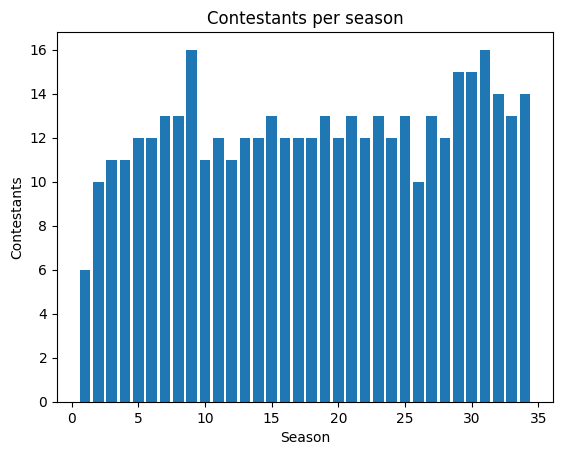

In [10]:
season_counts = df.groupby("season")["celebrity_name"].nunique().sort_index()

plt.figure()
plt.bar(season_counts.index.astype(int), season_counts.values)
plt.xlabel("Season")
plt.ylabel("Contestants")
plt.title("Contestants per season")
plt.show()


## 8.2 平均在场人数随周数下降（验证 active 定义合理）

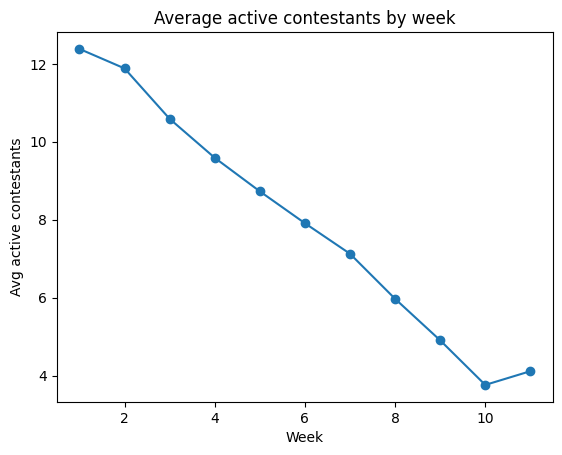

In [11]:
active_summary = (week_panel[week_panel["active"]]
                  .groupby(["season","week"], as_index=False)
                  .agg(active_contestants=("celebrity_name","nunique")))

avg_active_by_week = active_summary.groupby("week", as_index=False)["active_contestants"].mean()

plt.figure()
plt.plot(avg_active_by_week["week"], avg_active_by_week["active_contestants"], marker="o")
plt.xlabel("Week")
plt.ylabel("Avg active contestants")
plt.title("Average active contestants by week")
plt.show()

## 8.3 年龄分布、行业分布（为 Q3）

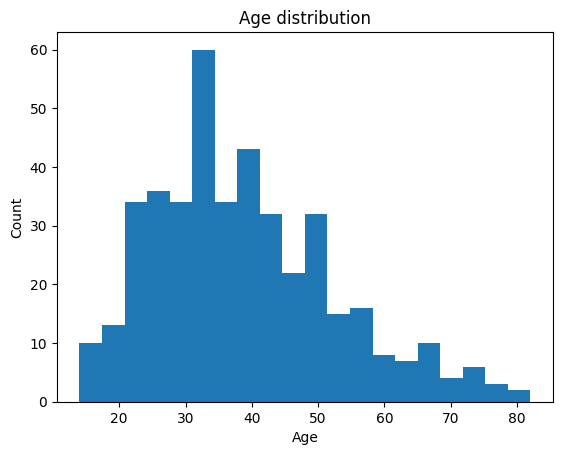

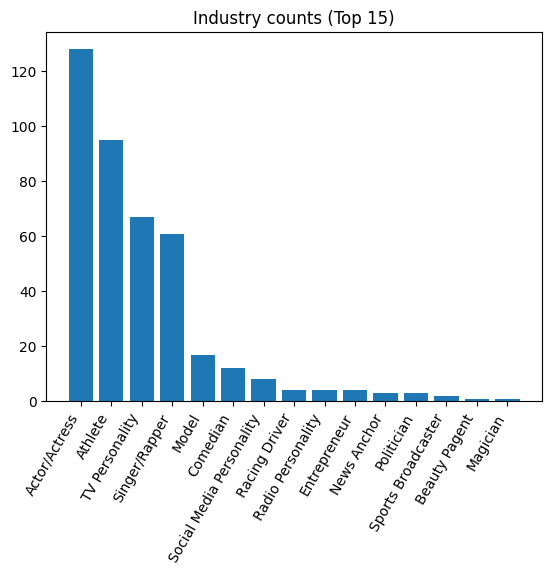

In [12]:
plt.figure()
plt.hist(df["celebrity_age_during_season"].dropna(), bins=20)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age distribution")
plt.show()

top_ind = df["celebrity_industry"].value_counts().head(15)
plt.figure()
plt.bar(top_ind.index.astype(str), top_ind.values)
plt.xticks(rotation=60, ha="right")
plt.title("Industry counts (Top 15)")
plt.show()

# 9）Step 9：特殊事件 EDA（Withdrew、多淘汰、无人淘汰）

这一步是你这题的“灵魂”，因为 Q1 的约束只对“正常淘汰机制”成立。

## 9.1 Withdrew（你已发现有10个）

### 结论

**Withdrew=退赛，不是投票淘汰** → Q1 不用其作为淘汰约束样本。

In [13]:
withdrew_df = df[df["results"].astype(str).str.contains("Withdrew", case=False, na=False)][
    ["season","celebrity_name","results","placement"]
].copy()

print("withdrew:", len(withdrew_df))
withdrew_df.sort_values(["season","celebrity_name"])

withdrew: 10


,season,celebrity_name,results,placement
24,3,Sara Evans,Withdrew,6
66,7,Misty May-Treanor,Withdrew,10
98,9,Tom DeLay,Withdrew,13
177,16,Dorothy Hamill,Withdrew,12
199,18,Billy Dee Williams,Withdrew,10
247,21,Kim Zolciak-Biermann,Withdrew,11
243,21,Tamar Braxton,Withdrew,5
325,28,Ray Lewis,Withdrew,11
348,29,Jeannie Mai,Withdrew,9
366,31,Selma Blair,Withdrew,12


## 9.2 淘汰事件分布：每周淘汰几人（elim_n=0/1/2/3）

### 代码

In [14]:
def parse_elim_week(text):
    if pd.isna(text):
        return np.nan
    m = re.search(r"Eliminated\s+Week\s+(\d+)", str(text), flags=re.IGNORECASE)
    return int(m.group(1)) if m else np.nan

df["elim_week"] = df["results"].apply(parse_elim_week)

elim_events = df.dropna(subset=["elim_week"])[["season","celebrity_name","elim_week","results"]].copy()
elim_events = elim_events[~elim_events["results"].astype(str).str.contains("Withdrew", case=False, na=False)]
elim_events = elim_events.rename(columns={"elim_week":"week"})

elim_count = elim_events.groupby(["season","week"], as_index=False).agg(elim_n=("celebrity_name","nunique"))
elim_count["elim_n"].value_counts().sort_index()

elim_n
1    231
2     32
3      1
Name: count, dtype: int64

### 你要写出的结论（Q1 样本选择）

* 主模型优先用：`elim_n=1` 的周（最干净，论文最好写）
* `elim_n=2/3`：作为扩展或单独讨论
* `elim_n=0`：无人淘汰周（通常跳过或特殊处理）

# 10）Step 10：为后续建模准备“周内标准化指标”（percent / rank）

## 目的

让不同周可比较，且对评委人数差异鲁棒。

### 10.1 judge_share（percent 赛制用）

In [15]:
week_panel["judge_share"] = np.nan

for (s, w), sub in week_panel.groupby(["season","week"]):
    sub_active = sub[sub["active"]]
    if len(sub_active) == 0:
        continue
    denom = sub_active["judge_total"].sum()
    if denom <= 0:
        continue
    week_panel.loc[sub_active.index, "judge_share"] = sub_active["judge_total"] / denom


### 10.2 judge_rank（rank 赛制用）

In [16]:
week_panel["judge_rank"] = np.nan

for (s, w), sub in week_panel.groupby(["season","week"]):
    sub_active = sub[sub["active"]].copy()
    if len(sub_active) == 0:
        continue
    sub_active["judge_rank_tmp"] = (-sub_active["judge_total"]).rank(method="min")
    week_panel.loc[sub_active.index, "judge_rank"] = sub_active["judge_rank_tmp"].values

# 11）Step 11：EDA 最终交付物（你报告里应该放什么）

你写论文/报告时，EDA 部分建议输出：

## 必放表（3张）

1. **数据概览表**：行列数、season数、score列数、withdrew数
2. **结构性缺失说明表**：每季 max_existing_week（证明周数不同）
3. **淘汰事件分布**：elim_n 的频数（证明多人淘汰存在）

## 必放图（3–5张）

* 每季参赛人数柱状图
* 平均在场人数随周数下降折线图
* 年龄分布直方图
* 行业Top15柱状图
* （可选）judge_count 分布条形图

## 必写“坑点记录”（写进假设/数据处理）

* N/A 是结构性缺失（评委不存在或周不存在）→ 不做数值填补
* bonus/多舞均分可能导致单评委分数>10 → 不当异常删除
* Withdrew 属于退赛，不是投票淘汰 → Q1 约束样本剔除
* 存在多人淘汰/无人淘汰周 → Q1 主模型先用 elim_n=1

---

# 12）你下一步怎么衔接到 Q1（最标准做法）

你现在有了 `week_panel`、`elim_events`、`elim_count`。
Q1 最稳的样本筛选条件（建议写进论文）：

* season 在 **3–27**（percent 赛制）
* week_exists=True
* 当周 `elim_n = 1`
* 剔除 Withdrew 相关周/人

然后再做“倒推投票份额”（最大熵/线性规划），这就是下一段建模。

---

如果你愿意，我下一条会把 **EDA 的最后一步“生成建模用干净数据集（model_df）”**写出来：
一行 = `(season, week, celebrity)`，带上 `judge_share`、`judge_rank`、`active`、`is_eliminated_this_week`、`elim_n`、`is_withdrew_season` 等字段，让你直接进入 Q1。


下面就是你要的 **“EDA 最后一步：生成干净的建模数据集 `model_df`”** 的完整代码（可直接复制进 ipynb 跑）。
输出 `model_df` 一行 = `(season, week, celebrity)`，并带上你点名的字段：

* `judge_share`（percent 赛制用）
* `judge_rank`（rank 赛制用）
* `active`（当周是否仍在比赛）
* `is_eliminated_this_week`
* `elim_n`（该周淘汰人数）
* `is_withdrew_season`（该选手该季是否退赛）
* 额外我也给了 `withdrew_event_week`（推断退赛发生周，方便你剔除 bad weeks）

In [17]:
import pandas as pd
import numpy as np
import re

# =========================
# 0) 读取数据 & 基本列识别
# =========================
CSV_PATH = "2026_MCM_Problem_C_Data.csv"
raw = pd.read_csv(CSV_PATH)

score_cols = [c for c in raw.columns if re.match(r"week\d+_judge\d+_score", c)]
week_nums = sorted({int(re.search(r"week(\d+)_judge", c).group(1)) for c in score_cols})

id_cols = [
    "celebrity_name","ballroom_partner","celebrity_industry",
    "celebrity_homestate","celebrity_homecountry/region",
    "celebrity_age_during_season","season","results","placement"
]
id_cols = [c for c in id_cols if c in raw.columns]

df = raw.copy()

# N/A -> NaN，分数转 float
for c in score_cols:
    df[c] = pd.to_numeric(df[c].replace("N/A", np.nan), errors="coerce")

# ====================================
# 1) week_exists: 判定某季某周是否存在
# ====================================
week_exists_rows = []
for s in sorted(df["season"].unique()):
    sub = df[df["season"] == s]
    for w in week_nums:
        cols_w = [c for c in score_cols if c.startswith(f"week{w}_")]
        exists = sub[cols_w].notna().any().any()      # 任意人任意评委有值 => 该周存在
        week_exists_rows.append({"season": int(s), "week": int(w), "week_exists": bool(exists)})

week_exists_df = pd.DataFrame(week_exists_rows)

# ==========================================
# 2) 宽表 -> 长表 -> 周面板 week_panel（核心）
#    一行=(season, celebrity, week)
# ==========================================
# (a) 宽 -> 长
long_rows = []
pat = re.compile(r"week(\d+)_judge(\d+)_score")

for col in score_cols:
    m = pat.match(col)
    w = int(m.group(1))
    j = int(m.group(2))
    tmp = df[id_cols].copy()
    tmp["week"] = w
    tmp["judge_id"] = j
    tmp["score"] = df[col].values
    long_rows.append(tmp)

long = pd.concat(long_rows, ignore_index=True)
long = long.sort_values(["season","celebrity_name","week","judge_id"]).reset_index(drop=True)

# (b) 长 -> 周面板：聚合 judge_total / mean / count
g = long.groupby(["season","celebrity_name","week"], as_index=False)

week_panel = g.agg(
    judge_count=("score", lambda x: int(x.notna().sum())),
    judge_total=("score", lambda x: float(np.nansum(x.values))),
    judge_mean=("score", lambda x: float(np.nanmean(x.values)) if np.any(~np.isnan(x.values)) else np.nan),
)

# (c) 合并 week_exists 并剔除“不存在周”
week_panel = week_panel.merge(week_exists_df, on=["season","week"], how="left")
week_panel = week_panel[week_panel["week_exists"]].copy()

# (d) active：总分>0 表示仍在比赛（题干规则：淘汰后记0）
week_panel["active"] = week_panel["judge_total"] > 0

# ==========================================
# 3) 周内标准化：judge_share & judge_rank
#    只在 active 集合里计算，inactive 填 NaN
# ==========================================
week_panel["judge_share"] = np.nan
week_panel["judge_rank"]  = np.nan

for (s, w), sub in week_panel.groupby(["season","week"]):
    sub_active = sub[sub["active"]].copy()
    if len(sub_active) == 0:
        continue

    denom = sub_active["judge_total"].sum()
    if denom > 0:
        week_panel.loc[sub_active.index, "judge_share"] = sub_active["judge_total"] / denom

    # 总分越高排名越靠前（1最好）
    ranks = (-sub_active["judge_total"]).rank(method="min")
    week_panel.loc[sub_active.index, "judge_rank"] = ranks.values

# =====================================================
# 4) 解析淘汰事件 elim_events + 每周淘汰人数 elim_n
#    注意：Withdrew 不是投票淘汰 => 从 elim_events 剔除
# =====================================================
def parse_elim_week(text):
    if pd.isna(text):
        return np.nan
    m = re.search(r"Eliminated\s+Week\s+(\d+)", str(text), flags=re.IGNORECASE)
    return int(m.group(1)) if m else np.nan

df["elim_week"] = df["results"].apply(parse_elim_week)

# Withdrew 标记（按 season-celebrity）
df["is_withdrew_season"] = df["results"].astype(str).str.contains("Withdrew", case=False, na=False)

# elim_events：只保留 Eliminated Week X 且排除 Withdrew
elim_events = df.dropna(subset=["elim_week"]).copy()
elim_events = elim_events[~elim_events["is_withdrew_season"]]
elim_events = elim_events[["season","celebrity_name","elim_week"]].rename(columns={"elim_week":"week"})

# 每季每周淘汰人数（elim_n）
elim_count = elim_events.groupby(["season","week"], as_index=False).agg(elim_n=("celebrity_name","nunique"))

# =====================================================
# 5) 推断 withdrew_event_week（results没写周时用分数轨迹推）
#    规则：从“有分>0”开始，找第一个变成 0 分的存在周
# =====================================================
# 先准备 withdrew 人列表
withdrew_people = df[df["is_withdrew_season"]][["season","celebrity_name"]].drop_duplicates()

infer_rows = []
for _, r in withdrew_people.iterrows():
    s = int(r["season"])
    name = r["celebrity_name"]

    sub = (week_panel[(week_panel["season"]==s) & (week_panel["celebrity_name"]==name)]
           .sort_values("week"))

    weeks  = sub["week"].values.astype(int)
    totals = sub["judge_total"].values.astype(float)

    active_mask = totals > 0
    if active_mask.any():
        first_active = weeks[active_mask].min()
        last_active  = weeks[active_mask].max()
        # 从第一次有分开始，找第一个变0分的周
        zero_after = weeks[(weeks >= first_active) & (totals == 0)]
        withdrew_event_week = int(zero_after.min()) if len(zero_after) > 0 else np.nan
    else:
        first_active = np.nan
        last_active = np.nan
        withdrew_event_week = np.nan

    infer_rows.append({
        "season": s,
        "celebrity_name": name,
        "withdrew_event_week": withdrew_event_week,
        "withdrew_last_active_week": last_active
    })

withdrew_infer = pd.DataFrame(infer_rows)

# =====================================================
# 6) 组装 model_df（最终干净建模表）
#    目标：一行=(season, week, celebrity)
# =====================================================
# (a) 把静态信息 merge 到 week_panel
static = df[id_cols + ["is_withdrew_season"]].drop_duplicates(subset=["season","celebrity_name"]).copy()

model_df = week_panel.merge(
    static,
    on=["season","celebrity_name"],
    how="left"
)

# (b) 加上淘汰人数 elim_n（没有记录就视为0）
model_df = model_df.merge(elim_count, on=["season","week"], how="left")
model_df["elim_n"] = model_df["elim_n"].fillna(0).astype(int)

# (c) is_eliminated_this_week：该选手是否在该周被淘汰（仅对 Eliminated Week X）
model_df = model_df.merge(
    elim_events.assign(is_eliminated_this_week=True),
    on=["season","celebrity_name","week"],
    how="left"
)
model_df["is_eliminated_this_week"] = model_df["is_eliminated_this_week"].fillna(False)

# (d) 加上 withdrew_event_week（方便你后面剔除 bad weeks）
model_df = model_df.merge(withdrew_infer, on=["season","celebrity_name"], how="left")

# (e) 额外常用：当周在场人数（周内标准化、约束构造常用）
active_counts = (model_df[model_df["active"]]
                 .groupby(["season","week"], as_index=False)
                 .agg(n_active=("celebrity_name","nunique")))

model_df = model_df.merge(active_counts, on=["season","week"], how="left")
model_df["n_active"] = model_df["n_active"].fillna(0).astype(int)

# (f) 给赛制标签（可选，但建议加，Q2/Q1筛选更方便）
def scheme_by_season(season: int):
    if season <= 2:
        return "rank"
    elif 3 <= season <= 27:
        return "percent"
    else:
        return "rank_bottom2"   # 合理假设：28+有底二机制

model_df["scheme"] = model_df["season"].astype(int).apply(scheme_by_season)

# 排序方便看
model_df = model_df.sort_values(["season","week","celebrity_name"]).reset_index(drop=True)

print("model_df shape:", model_df.shape)
model_df.head(20)

model_df shape: (4199, 24)


,season,celebrity_name,week,judge_count,judge_total,judge_mean,week_exists,active,judge_share,judge_rank,ballroom_partner,celebrity_industry,celebrity_homestate,celebrity_homecountry/region,celebrity_age_during_season,results,placement,is_withdrew_season,elim_n,is_eliminated_this_week,withdrew_event_week,withdrew_last_active_week,n_active,scheme
0,1,Evander Holyfield,1,3,18.0,6.000000,True,True,0.165138,4.0,Edyta Sliwinska,Athlete,Alabama,United States,42,Eliminated Week 3,5,False,0,False,NaN,NaN,6,rank
1,1,Joey McIntyre,1,3,20.0,6.666667,True,True,0.183486,1.0,Ashly DelGrosso,Singer/Rapper,Massachusetts,United States,32,3rd Place,3,False,0,False,NaN,NaN,6,rank
2,1,John O'Hurley,1,3,20.0,6.666667,True,True,0.183486,1.0,Charlotte Jorgensen,Actor/Actress,Maine,United States,50,2nd Place,2,False,0,False,NaN,NaN,6,rank
3,1,Kelly Monaco,1,3,13.0,4.333333,True,True,0.119266,6.0,Alec Mazo,Actor/Actress,Pennsylvania,United States,29,1st Place,1,False,0,False,NaN,NaN,6,rank
4,1,Rachel Hunter,1,3,20.0,6.666667,True,True,0.183486,1.0,Jonathan Roberts,Model,NaN,New Zealand,35,Eliminated Week 4,4,False,0,False,NaN,NaN,6,rank
5,1,Trista Sutter,1,3,18.0,6.000000,True,True,0.165138,4.0,Louis van Amstel,TV Personality,Indiana,United States,32,Eliminated Week 2,6,False,0,False,NaN,NaN,6,rank
6,1,Evander Holyfield,2,3,14.0,4.666667,True,True,0.115702,6.0,Edyta Sliwinska,Athlete,Alabama,United States,42,Eliminated Week 3,5,False,1,False,NaN,NaN,6,rank
7,1,Joey McIntyre,2,3,21.0,7.000000,True,True,0.173554,3.0,Ashly DelGrosso,Singer/Rapper,Massachusetts,United States,32,3rd Place,3,False,1,False,NaN,NaN,6,rank
8,1,John O'Hurley,2,3,26.0,8.666667,True,True,0.214876,1.0,Charlotte Jorgensen,Actor/Actress,Maine,United States,50,2nd Place,2,False,1,False,NaN,NaN,6,rank
9,1,Kelly Monaco,2,3,17.0,5.666667,True,True,0.140496,5.0,Alec Mazo,Actor/Actress,Pennsylvania,United States,29,1st Place,1,False,1,False,NaN,NaN,6,rank


## 你跑完后会得到什么？

`model_df` 至少包含这些你需要的字段（你可以 `model_df.columns` 看）：

* `season, week, celebrity_name`
* `judge_total, judge_mean, judge_count`
* `week_exists, active`
* `judge_share, judge_rank`
* `is_eliminated_this_week`
* `elim_n`
* `is_withdrew_season`
* `withdrew_event_week, withdrew_last_active_week`
* `n_active`
* `scheme`


In [19]:
OUT_PATH = "model_df.csv"
model_df.to_csv(OUT_PATH, index=False)
print("saved:", OUT_PATH)

saved: model_df.csv
